***Using Node2Vec to Create Node Embeddings***

This notebook uses an implementation of node2vec algorithm to generate node embeddings.

This notebook will start an adjacency list file and:
1. Load this graph into NetworkX, and using the largest connnected component.
2. Useh the Node2Vec library to generate embeddings, saved to a file.
3. Use T-SNE to reduce the dimensionality of these embeddings.
4. Visualize the embeddings in 2-dimensions.

First, install libraries.

In [2]:
! pip install node2vec
! pip install karateclub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.9 MB/s eta 0:00:00
  Created wheel for karateclub: filename=karateclub-1.3.3-py3-none-any.whl size=101983 sha256=fc4630d2ac718245bf1f9b8e4e7d1a8a0884f779577bca51215ea38230117d4b
  Store

In [3]:
# load data

!gdown --id 1jbPTV9RP0plLH524PZqsiVYpClG73829 # download sample edge list file
!gdown --id 1IVMAltcyqtxBOY4PwHktNZuj3KYytAkP # download sample adjacency list file
!gdown --id 1gL63dwzlfjSfBHl8b-JRjBnjyRBhbHAZ # download node attributes csv file



/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jbPTV9RP0plLH524PZqsiVYpClG73829
To: /content/edge_list_testlatest.txt
100% 1.02M/1.02M [00:00<00:00, 169MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IVMAltcyqtxBOY4PwHktNZuj3KYytAkP
To: /content/adjacency_list_test.txt
100% 1.08M/1.08M [00:00<00:00, 161MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: http

In [4]:
from node2vec import Node2Vec
import networkx as nx
import pandas as pd
import numpy as np
import json
from itertools import count


from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline


Load the graph data into NetworkX.

Then read in the node attributes and affix them to the NetworkX graph.

In [5]:
# social_graph = nx.read_edgelist('edge_list_testlatest.txt') # This can also be run with the edgelist version of the data
social_graph = nx.read_adjlist('adjacency_list_test.txt')


node_attr = pd.read_csv('/content/node_attributes_hashed.csv', encoding = "ISO-8859-1")
node_attr = node_attr[['hashedid','company_type','position_type']]
node_attr.info()
social_graph.number_of_edges(), social_graph.number_of_nodes()

node_attr = node_attr.set_index('hashedid')
attribute_dict = node_attr.to_dict(orient='index')
nx.set_node_attributes(social_graph, attribute_dict)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hashedid       1947 non-null   object
 1   company_type   1947 non-null   object
 2   position_type  1947 non-null   object
dtypes: object(3)
memory usage: 45.8+ KB


Our original graph is disconnected. So, we only deal with its largest connected component.

In [6]:
social_graph = social_graph.subgraph(sorted(nx.connected_components(social_graph), key=len, reverse=True)[0])  #A

social_graph.number_of_edges(), social_graph.number_of_nodes()

(12222, 1698)

For visualization purposes, namely, to colorize our nodes, we encode the *company_type* attributes. Later on, we will use this encoding as a color map.

In [7]:
groups = set(nx.get_node_attributes(social_graph,'company_type').values())
nx.get_node_attributes(social_graph,'company_type')
mapping = dict(zip(sorted(groups),count()))
attr_values = [mapping[attribute_dict[node]['company_type']] for node in social_graph.nodes()]

Generate the node embeddings.

* #A  Precompute probabilities and generate walks
* #B Generate embeddings. The batch_words parameter is because much of this function is derived from the Word2Vec algorithm.
* #C Save embedding in a file to disk.


In [8]:
node2vec = Node2Vec(social_graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  #A
model = node2vec.fit(window=10, min_count=1, batch_words=4)  #B
model.wv.save_word2vec_format('EMBEDDING_FILENAME') #C


Computing transition probabilities:   0%|          | 0/1698 [00:00<?, ?it/s]

Read in the embeddings that were saved to disk.


In [9]:
with open("EMBEDDING_FILENAME", "r") as social:
    lines = social.readlines()

embedded_lines = [x.split(' ')[1:] for x in lines[1:]]
n2v_embeddings = []
for line in embedded_lines:
    new_line = [float(y) for y in line] #B
    n2v_embeddings.append(new_line)

In [13]:
type(n2v_embeddings)

list

Finally, use T-SNE to reduce the dimension of the embeddings and visualize using matplotlib. Colors correspond to company_type.


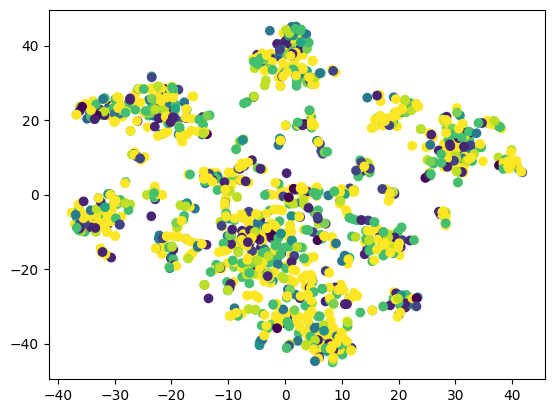

In [15]:
np_n2v = np.array(n2v_embeddings)
tsne_model = TSNE(learning_rate=800,  metric='cosine', n_iter=500)
tsne_features = tsne_model.fit_transform(np_n2v)

# Select the 0th feature: xs
xs = tsne_features[:,0]
# Select the 1st feature: ys
ys = tsne_features[:,1]

plt.scatter(xs,ys, c=attr_values)
plt.show()
